Before running this file: <br>
Run the energy plus simulations for all the scenarios and efficiency measures and put the csv outputs into the correct EPS_Results subfolders

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
#from sys import stdout
import json
import os
import glob
import shapefile as shp
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import random
import matplotlib.colors as colors
import matplotlib.cm as cmx
import csv as csv
from scipy.interpolate import interp1d
import cPickle as pickle
import sys

import matplotlib.colors as colors2
import matplotlib.cm as cmx

import matplotlib.lines as mlines
from scipy.interpolate import spline

import seaborn as sns
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'in', 'xtick.major.size': 4.0, 'ytick.direction': 'in', 'ytick.major.size': 4.0, \
               'xtick.minor.size': 3.0, 'ytick.minor.size': 3.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', 'grid.linewidth': 0.})

%matplotlib inline

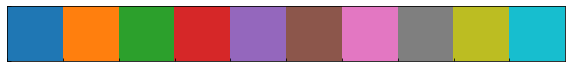

In [4]:
# choose a good colormap
current_palette = sns.color_palette("tab10", 10)
sns.palplot(current_palette)
current_palette = []

In [5]:
listFile=glob.glob('../EPS_Results/Standard_efficiency/*control.csv')
print len(listFile)
A = []
for f in listFile:
    A.append( f.split('efficiency')[1].split('_')[0][1:] )
listFile=glob.glob('../EPS_Results/Standard_efficiency/*experiment1.csv')
print len(listFile)
B = []
for f in listFile:
    B.append( f.split('efficiency')[1].split('_')[0][1:] )
listFile=glob.glob('../EPS_Results/Standard_efficiency/*experiment2.csv')
print len(listFile)
print set(B)-set(A)

318
318
318
set([])


The next two cells are required for plotting the energy use results on a google map

In [6]:
with open('../SkeletonFiles/header.txt', 'r') as f:
    header = f.read()

with open('../SkeletonFiles/footer.txt', 'r') as f:
    footer = f.read()

In [7]:
with open('../SkeletonFiles/polygon_header.txt', 'r') as f:
    polygon_header = f.read()

with open('../SkeletonFiles/polygon_footer.txt', 'r') as f:
    polygon_footer = f.read()
    
with open('../SkeletonFiles/line.txt', 'r') as f:
    liner = f.read()

def get_polygon_line(latitude, longitude):
    return '{lat:'+str(latitude)+', lng:'+str(longitude)+'},\n'

def add_box(lonLL,latLL,lonUR,latUR):
    # draw line LL to LR
    codeL1 = liner.replace('lat1', str(latLL))
    codeL1 = codeL1.replace('long1', str(lonLL))
    codeL1 = codeL1.replace('lat2', str(latLL))
    codeL1 = codeL1.replace('long2', str(lonUR))
    # draw line LR to UR
    codeL2 = liner.replace('lat1', str(latLL))
    codeL2 = codeL2.replace('long1', str(lonUR))
    codeL2 = codeL2.replace('lat2', str(latUR))
    codeL2 = codeL2.replace('long2', str(lonUR))
    # draw line UR to UL
    codeL3 = liner.replace('lat1', str(latUR))
    codeL3 = codeL3.replace('long1', str(lonUR))
    codeL3 = codeL3.replace('lat2', str(latUR))
    codeL3 = codeL3.replace('long2', str(lonLL))
    # draw line UR to UL
    codeL4 = liner.replace('lat1', str(latUR))
    codeL4 = codeL4.replace('long1', str(lonLL))
    codeL4 = codeL4.replace('lat2', str(latLL))
    codeL4 = codeL4.replace('long2', str(lonLL))
    codeBox = codeL1+codeL2+codeL3+codeL4
    return codeBox

In [8]:
print len( glob.glob('../EPS_Results/Standard_efficiency/*control.csv') )
print len( glob.glob('../EPS_Results/Standard_efficiency/*experiment1.csv') )
print len( glob.glob('../EPS_Results/Standard_efficiency/*experiment2.csv') )

fileList = glob.glob('../EPS_Results/Standard_efficiency/*control.csv')
kWh = 3600000
hours = np.arange(1,25)

318
318
318


In [9]:
# get new and old occupancy each building and positions
SDLIDs = []
for f in fileList:
    SDLIDs.append( f.split('efficiency/')[1].split('_')[0] )
with open('../PickledData/UBEMdata/allTestBuildings.pickle', 'rb') as f:
    allTestBuildings = pickle.load(f)
with open('../PickledData/UBEMdata/SDLBuildings.pickle', 'rb') as f:
    SDLBuildings = pickle.load(f)
    
# make sure all fileLists have the same order
fileList2, fileList3 = [], []
for sID in SDLIDs:
    for entry in glob.glob('../EPS_Results/Standard_efficiency/*experiment1.csv'):
        if sID in entry:
            fileList2.append( entry )
    for entry in glob.glob('../EPS_Results/Standard_efficiency/*experiment2.csv'):
        if sID in entry:
            fileList3.append( entry )

In [10]:
# want to look at Lighting, Plugloads, DHW, Heat, Cool

heatUse, coolUse = np.zeros((len(fileList),24*4)), np.zeros((len(fileList),24*4))
DHWUse = np.zeros((len(fileList),24*4))
PLGUse, LGTUse = np.zeros((len(fileList),24*4)), np.zeros((len(fileList),24*4))
results = {}
for j, f in enumerate(fileList):
    idx = f.split('efficiency/')[1].split('_')[0]
    results[idx] = {}
    results[idx]['reference'] = {}
    with open(f, 'rb') as csvfile:
        fileReader = csv.reader(csvfile, delimiter=',')
        headings = []
        for k, row in enumerate(fileReader):
            #print k
            if k < 1:
                for entry in row:
                    headings.append( entry )
                #print headings
            else:
                #print row
                for l, entry in enumerate(row):
                    #print l, headings[l]
                    if 'Zone Lights Electric' in headings[l]:
                        LGTUse[j,k-1]=LGTUse[j,k-1]+float(entry)/kWh
                    if 'Zone Electric Equipment' in headings[l]:
                        PLGUse[j,k-1]=PLGUse[j,k-1]+float(entry)/kWh
                    if 'Zone Ideal Loads Supply Air Total Heating Energy' in headings[l]:
                        heatUse[j,k-1]=heatUse[j,k-1]+float(entry)/kWh
                    if 'Zone Ideal Loads Supply Air Total Cooling Energy' in headings[l]:
                        coolUse[j,k-1]=coolUse[j,k-1]+float(entry)/kWh
                    if ':Water Use Equipment Heating Energy' in headings[l]:
                        DHWUse[j,k-1]=DHWUse[j,k-1]+float(entry)/kWh
    results[idx]['reference']['plg'] = PLGUse[j,:]
    results[idx]['reference']['lgt'] = LGTUse[j,:]
    results[idx]['reference']['dhw'] = DHWUse[j,:]
    results[idx]['reference']['het'] = heatUse[j,:]
    results[idx]['reference']['col'] = coolUse[j,:]

In [11]:
LGTUseNew0 = np.copy(LGTUse)
PLGUseNew0 = np.copy(PLGUse)
heatUseNew0 = np.copy(heatUse)
coolUseNew0 = np.copy(coolUse)
DHWUseNew0 = np.copy(DHWUse)

In [12]:
# want to look at Lighting, Plugloads, DHW, Heat, Cool
heatUse, coolUse = np.zeros((len(fileList),24*4)), np.zeros((len(fileList),24*4))
DHWUse = np.zeros((len(fileList),24*4))
PLGUse, LGTUse = np.zeros((len(fileList),24*4)), np.zeros((len(fileList),24*4))

for j, f in enumerate(fileList2):
    idx = f.split('efficiency/')[1].split('_')[0]
    results[idx]['scenario1'] = {}
    with open(f, 'rb') as csvfile:
        fileReader = csv.reader(csvfile, delimiter=',')
        headings = []
        for k, row in enumerate(fileReader):
            #print k
            if k < 1:
                for entry in row:
                    headings.append( entry )
                #print headings
            else:
                #print row
                for l, entry in enumerate(row):
                    #print l, headings[l]
                    if 'Zone Lights Electric' in headings[l]:
                        LGTUse[j,k-1]=LGTUse[j,k-1]+float(entry)/kWh
                    if 'Zone Electric Equipment' in headings[l]:
                        PLGUse[j,k-1]=PLGUse[j,k-1]+float(entry)/kWh
                    if 'Zone Ideal Loads Supply Air Total Heating Energy' in headings[l]:
                        heatUse[j,k-1]=heatUse[j,k-1]+float(entry)/kWh
                    if 'Zone Ideal Loads Supply Air Total Cooling Energy' in headings[l]:
                        coolUse[j,k-1]=coolUse[j,k-1]+float(entry)/kWh
                    if ':Water Use Equipment Heating Energy' in headings[l]:
                        DHWUse[j,k-1]=DHWUse[j,k-1]+float(entry)/kWh
    results[idx]['scenario1']['plg'] = PLGUse[j,:]
    results[idx]['scenario1']['lgt'] = LGTUse[j,:]
    results[idx]['scenario1']['dhw'] = DHWUse[j,:]
    results[idx]['scenario1']['het'] = heatUse[j,:]
    results[idx]['scenario1']['col'] = coolUse[j,:]

In [13]:
LGTUseNew1 = np.copy(LGTUse)
PLGUseNew1 = np.copy(PLGUse)
heatUseNew1 = np.copy(heatUse)
coolUseNew1 = np.copy(coolUse)
DHWUseNew1 = np.copy(DHWUse)

In [14]:
# want to look at Lighting, Plugloads, DHW, Heat, Cool

heatUse, coolUse = np.zeros((len(fileList),24*4)), np.zeros((len(fileList),24*4))
DHWUse = np.zeros((len(fileList),24*4))
PLGUse, LGTUse = np.zeros((len(fileList),24*4)), np.zeros((len(fileList),24*4))

for j, f in enumerate(fileList3):
    idx = f.split('efficiency/')[1].split('_')[0]
    results[idx]['scenario2'] = {}
    with open(f, 'rb') as csvfile:
        fileReader = csv.reader(csvfile, delimiter=',')
        headings = []
        for k, row in enumerate(fileReader):
            #print k
            if k < 1:
                for entry in row:
                    headings.append( entry )
                #print headings
            else:
                #print row
                for l, entry in enumerate(row):
                    #print l, headings[l]
                    if 'Zone Lights Electric' in headings[l]:
                        LGTUse[j,k-1]=LGTUse[j,k-1]+float(entry)/kWh
                    if 'Zone Electric Equipment' in headings[l]:
                        PLGUse[j,k-1]=PLGUse[j,k-1]+float(entry)/kWh
                    if 'Zone Ideal Loads Supply Air Total Heating Energy' in headings[l]:
                        heatUse[j,k-1]=heatUse[j,k-1]+float(entry)/kWh
                    if 'Zone Ideal Loads Supply Air Total Cooling Energy' in headings[l]:
                        coolUse[j,k-1]=coolUse[j,k-1]+float(entry)/kWh
                    if ':Water Use Equipment Heating Energy' in headings[l]:
                        DHWUse[j,k-1]=DHWUse[j,k-1]+float(entry)/kWh
                        
    # change the heatUse
    bID = f.split('efficiency/')[1].split('_')[0]
    #refOcc = np.round(allTestBuildings[bID]['total_occupancy'])
    mobOcc = SDLBuildings[bID]['total_occupancy24']
    maxOcc = np.max(SDLBuildings[bID]['total_occupancy24'])
                        
    results[idx]['scenario2']['plg'] = PLGUse[j,:]
    results[idx]['scenario2']['lgt'] = LGTUse[j,:]
    results[idx]['scenario2']['dhw'] = DHWUse[j,:]
    results[idx]['scenario2']['het'] = heatUse[j,:]
    results[idx]['scenario2']['col'] = coolUse[j,:]

In [15]:
LGTUseNew2 = np.copy(LGTUse)
PLGUseNew2 = np.copy(PLGUse)
heatUseNew2 = np.copy(heatUse)
coolUseNew2 = np.copy(coolUse)
DHWUseNew2 = np.copy(DHWUse)

In [16]:
tots = np.zeros((len(results),3))
counter = 0
for idx in results:
    tots[counter,0] = sum([sum(results[idx]['reference'][x]) for x in results[idx]['reference']])
    tots[counter,1] = sum([sum(results[idx]['scenario1'][x]) for x in results[idx]['scenario1']])
    tots[counter,2] = sum([sum(results[idx]['scenario2'][x]) for x in results[idx]['scenario2']])
    counter+=1

In [17]:
print 'Scenario 1 implies an average change of ', np.mean([(t[1]-t[0])/t[0] for t in tots])*100, '%'
print 'Scenario 2 implies an average change of ', np.mean([(t[2]-t[0])/t[0] for t in tots])*100, '%'

Scenario 1 implies an average change of  -3.43609655121108 %
Scenario 2 implies an average change of  -22.1705280145982 %


In [19]:
print 'Scenario 1 implies a median change of ', np.median([(t[1]-t[0])/t[0] for t in tots])*100, '%'
print 'Scenario 2 implies a median change of ', np.median([(t[2]-t[0])/t[0] for t in tots])*100, '%'

 Scenario 1 implies a median change of  -2.265645146959965 %
Scenario 2 implies a median change of  -20.683481697395695 %


In [20]:
TotalUse0 = heatUseNew0+DHWUseNew0+LGTUseNew0+PLGUseNew0+coolUseNew0
TotalUse1 = heatUseNew1+DHWUseNew1+LGTUseNew1+PLGUseNew1+coolUseNew1
TotalUse2 = heatUseNew2+DHWUseNew2+LGTUseNew2+PLGUseNew2+coolUseNew2

In [21]:
val = (np.sum(LGTUseNew0+PLGUseNew0+coolUseNew0)-np.sum(LGTUseNew1+PLGUseNew1+coolUseNew1))\
/np.sum(LGTUseNew0+PLGUseNew0+coolUseNew0)
print 'Scenario 1 implies electricity change of ', -val*100, '%'
val = (np.sum(heatUseNew0+DHWUseNew0)-np.sum(heatUseNew1+DHWUseNew1))/np.sum(heatUseNew0+DHWUseNew0)
print 'Scenario 1 implies gas change of ', -val*100, '%'
val = (np.sum(LGTUseNew0+PLGUseNew0+coolUseNew0)-np.sum(LGTUseNew2+PLGUseNew2+coolUseNew2))\
/np.sum(LGTUseNew0+PLGUseNew0+coolUseNew0)
print 'Scenario 2 implies electricity change of ', -val*100, '%'
val = (np.sum(heatUseNew0+DHWUseNew0)-np.sum(heatUseNew2+DHWUseNew2))/np.sum(heatUseNew0+DHWUseNew0)
print 'Scenario 2 implies gas change of ', -val*100, '%'

Scenario 1 implies electricity change of  -12.611702491225154 %
Scenario 1 implies gas change of  13.738276863083385 %
Scenario 2 implies electricity change of  -49.70912827248463 %
Scenario 2 implies gas change of  24.657300720645726 %


In [22]:
# plot electricity demands for a winter and summer day
heatUse, DHWUse, coolUse, PLGUse, LGTUse = [], [], [], [], []
heatUse.append(heatUseNew0), heatUse.append(heatUseNew1), heatUse.append(heatUseNew2)
DHWUse.append(DHWUseNew0), DHWUse.append(DHWUseNew1), DHWUse.append(DHWUseNew2)
coolUse.append(coolUseNew0), coolUse.append(coolUseNew1), coolUse.append(coolUseNew2)
PLGUse.append(PLGUseNew0), PLGUse.append(PLGUseNew1), PLGUse.append(PLGUseNew2)
LGTUse.append(LGTUseNew0), LGTUse.append(LGTUseNew1), LGTUse.append(LGTUseNew2)

(None, None, None)

winter gas use:  17495.272275087907
winter elec use:  176923.9978513528
winter 9-to-9 elec use:  133400.26065303705
winter gas use:  19869.96532548126
winter elec use:  155604.50946826366
winter 9-to-9 elec use:  114518.24690291713
winter gas use:  22490.353252192544
winter elec use:  89203.9820158734
winter 9-to-9 elec use:  53462.906687152536
summer gas use:  3138.5150873535754
summer elec use:  215514.29670232208
summer 9-to-9 elec use:  166922.5348410743
summer gas use:  2762.156495748775
summer elec use:  185353.35519165383
summer 9-to-9 elec use:  139799.14237485407
summer gas use:  1372.8179247856722
summer elec use:  107701.93490524916
summer 9-to-9 elec use:  71050.9501837366


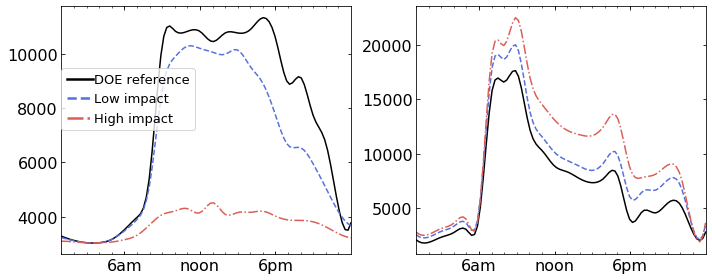

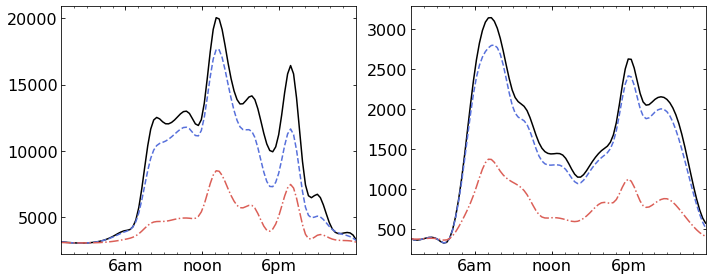

In [23]:
fs = 16
CPP = sns.color_palette("hls", 8)
# scenarioColors = [current_palette[0],current_palette[1],current_palette[2]]
scenarioColors = ['k',CPP[5],CPP[0]]
lineStyles = ['-','--','-.']
for season in ['winter', 'summer']:
    if season == 'winter':
        start = 0
        end = 24
    elif season == 'summer':
        start = 48
        end = 72
    fig = plt.figure(figsize = (10,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    axs = []
    axs.append(ax1), axs.append(ax2)
    for j in range(3):
        gasUse = np.sum(heatUse[j], axis=0)+np.sum(DHWUse[j], axis=0)
        elecUse = np.sum(coolUse[j], axis=0)+np.sum(PLGUse[j], axis=0)+np.sum(LGTUse[j], axis=0)    
        
        # interpolate the curves
        xnew = np.linspace(1, 24, num=100, endpoint=True)
        f1 = interp1d(hours, elecUse[start:end], kind='cubic')
        f2 = interp1d(hours, gasUse[start:end], kind='cubic')
        
        print season+' gas use: ', np.max(gasUse[start:end])
        print season+' elec use: ', np.sum(elecUse[start:end])#-elecUse[start+12]
        print season+' 9-to-9 elec use: ', np.sum(elecUse[start+8:end-3])
        
        for useType in range(2):
            if useType == 0:
                axs[useType].plot(xnew, f1(xnew), color=scenarioColors[j], linestyle=lineStyles[j])
                # y ticks
#                 axs[useType].set_yticks(np.arange(0,40001,10000)), axs[useType].set_yticks(np.arange(0,53000,1000), minor=True)
#                 axs[useType].set_yticklabels(['0','10','20','30','40']), ax1.set_ylim([0,49000]),                
            else:
                axs[useType].plot(xnew, f2(xnew), color=scenarioColors[j], linestyle=lineStyles[j])
                # y ticks
#                 axs[useType].set_yticks(np.arange(0,100000,25000)), axs[useType].set_yticks(np.arange(0,100000,2000), minor=True)
#                 axs[useType].set_yticklabels(['0','25','50','75',])#, ax1.set_ylim([0,64000]),
            # x ticks
            axs[useType].set_xticks(np.arange(6,24,6)), axs[useType].set_xticks(np.arange(1,24,1), minor=True)
            axs[useType].set_xticklabels(['6am', 'noon', '6pm']), axs[useType].set_xlim([1,24])
            # labels
#             axs[useType].set_ylabel('Energy Use (X$10^3$kWh)', fontsize=fs-1)
            axs[useType].tick_params(axis='both', which='major', labelsize=fs)
            axs[useType].yaxis.set_ticks_position('both')
            axs[useType].xaxis.set_ticks_position('both')
    fig.tight_layout()
    if season=='winter':
        bL = mlines.Line2D([], [], color=scenarioColors[0], linewidth=2.5, label='DOE reference')
        oL = mlines.Line2D([], [], color=scenarioColors[1], linewidth=2.5, label='Low impact', linestyle='--')
        gL = mlines.Line2D([], [], color=scenarioColors[2], linewidth=2.5, label='High impact', linestyle='-.')
        axs[0].legend(handles=[bL, oL, gL], fontsize=fs-3, handletextpad=0.1, loc=[0,0.5])

In [24]:
# make a histogram of total gas and electric usage in each season day
barElec = np.zeros((12))
barGas = np.zeros((12))
counter = 0
for season in ['winter', 'spring', 'summer', 'autumn']:
    if season == 'winter':
        start = 0
        end = 24
    elif season == 'spring':
        start = 24
        end = 48
    elif season == 'summer':
        start = 48
        end = 72
    elif season == 'autumn':
        start = 72
        end = 96 
    
    # for each scenario
    for j in range(3):
        gasUse = np.sum(heatUse[j], axis=0)+np.sum(DHWUse[j], axis=0)
        elecUse = np.sum(coolUse[j], axis=0)+np.sum(PLGUse[j], axis=0)+np.sum(LGTUse[j], axis=0) 
        barElec[counter] = np.sum(elecUse[start:end])
        barGas[counter] = np.sum(gasUse[start:end])
        counter+=1

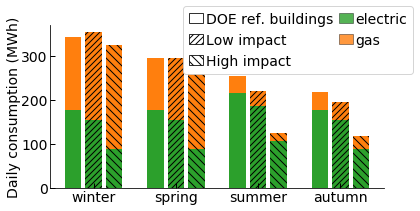

In [25]:
fs = 14
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot(111)
current_palette = sns.color_palette("tab10", 10)
# colors = [current_palette[0], current_palette[3]]
colors = [current_palette[2],current_palette[1]]
hatchling = [None, '////', '\\\\\\']
xbar = np.arange(12)
xbar[3:]+=1
xbar[6:]+=1
xbar[9:]+=1
for j in range(12):
    rem = j%3
    ax1.bar(xbar[j], barElec[j]/1000, color=colors[0], hatch=hatchling[rem])
    ax1.bar(xbar[j], barGas[j]/1000, bottom=barElec[j]/1000, color=colors[1], hatch=hatchling[rem])

ax1.tick_params(axis='x', labelsize=fs, pad=2)
ax1.tick_params(axis='y', labelsize=fs, pad=2)
ax1.set_ylabel('Daily consumption (MWh)', fontsize=fs, labelpad=0)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()  
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black') 
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params('both', length=5, width=1, which='major')
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False)

ax1.set_xticks([1,5,9,13])
ax1.set_xticklabels(['winter','spring','summer','autumn'])
# ax1.set_yticks(np.arange(0,1251,250))

r1 = plt.Rectangle((0, 0), 1, 1, fc=colors[0], alpha=0.8,  edgecolor='black', linewidth=0.5)
r2 = plt.Rectangle((0, 0), 1, 1, fc=colors[1], alpha=0.8,  edgecolor='black', linewidth=0.5)

h1 = plt.Rectangle((0, 0), 1, 1, fc='white', edgecolor='black', linewidth=0.8, hatch=hatchling[0])
h2 = plt.Rectangle((0, 0), 1, 1, fc='white', edgecolor='black', linewidth=0.8, hatch=hatchling[1])
h3 = plt.Rectangle((0, 0), 0.5, 1, fc='white', edgecolor='black', linewidth=0.8, hatch=hatchling[2])

ax1.legend([h1,h2,h3,r1,r2], ['DOE ref. buildings','Low impact', 'High impact', 'electric', 'gas'], fontsize=fs, \
           loc=[0.4,0.7], ncol=2, columnspacing=0.4, handlelength=1, handletextpad=0.2)

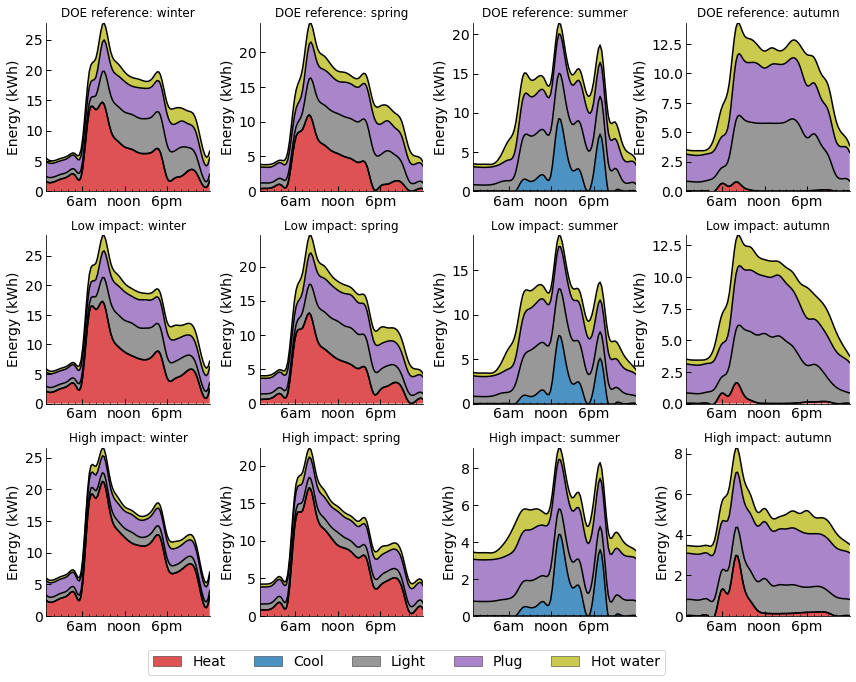

In [27]:
# make a figure break energy use broken down by load type for each season day in each scenario
SLabels = ['DOE reference', 'Low impact', 'High impact']
fig = plt.figure(figsize=(12,9))
fs = 14
# fig, ax = plt.subplots(2, 3, sharex='col', sharey='row')
# fig.set_size_inches(12,8)

counter = 0
for scenarioIndex in range(3):
    
    for season in ['winter', 'spring', 'summer', 'autumn']:
        counter+=1
        if season == 'winter':
            start = 0
            end = 24
        elif season == 'spring':
            start = 24
            end = 48
        elif season == 'summer':
            start = 48
            end = 72
        elif season == 'autumn':
            start = 72
            end = 96 

        ax1 = fig.add_subplot(3,4,counter)
            
        allUses = np.zeros((5,24))
        allUses[0,:] = np.sum(heatUse[scenarioIndex][:,start:end], axis=0)/1000
        allUses[1,:] = np.sum(coolUse[scenarioIndex][:,start:end], axis=0)/1000
        allUses[2,:] = np.sum(LGTUse[scenarioIndex][:,start:end], axis=0)/1000
        allUses[3,:] = np.sum(PLGUse[scenarioIndex][:,start:end], axis=0)/1000
        allUses[4,:] = np.sum(DHWUse[scenarioIndex][:,start:end], axis=0)/1000

        cumSumUses = []
        for j, a in enumerate(allUses):
            cumSumUses.append(np.sum(allUses[0:j+1,:], axis=0))   

        interpUses = np.zeros((len(cumSumUses),100))
        for j,y in enumerate(cumSumUses):
            xnew = np.linspace(1, 24, num=100, endpoint=True)
            f = interp1d(hours, y, kind='cubic')
            interpUses[j] = f(xnew)
        for a in interpUses:
            ax1.plot(xnew, a, color='k')
        ax1.fill_between(xnew, 0, interpUses[0], facecolor=current_palette[3], alpha=0.8)
        ax1.fill_between(xnew, interpUses[0], interpUses[1], facecolor=current_palette[0], alpha=0.8)
        ax1.fill_between(xnew, interpUses[1], interpUses[2], facecolor=current_palette[7], alpha=0.8)
        ax1.fill_between(xnew, interpUses[2], interpUses[3], facecolor=current_palette[4], alpha=0.8)
        ax1.fill_between(xnew, interpUses[3], interpUses[4], facecolor=current_palette[8], alpha=0.8)


        ax1.set_xticks(np.arange(6,24,6))
        ax1.set_xticks(np.arange(1,24,1), minor=True)
        ax1.set_xticklabels(['6am', 'noon', '6pm'])
        ax1.set_xlim([1,24])
        ax1.set_ylim([0,np.max(interpUses)])
        ax1.tick_params('both', length=5, width=1, which='major', labelsize=fs)
        ax1.spines["top"].set_visible(False)  
        ax1.spines["right"].set_visible(False)
        ax1.set_ylabel('Energy (kWh)', fontsize=fs)
        str111 = SLabels[scenarioIndex]+': '+season
        ax1.set_title(str111)

fig.tight_layout()
    
r1 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[3], alpha=0.8,  edgecolor='black', linewidth=0.5)
r3 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[7], alpha=0.8,  edgecolor='black', linewidth=0.5)
r4 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[4], alpha=0.8,  edgecolor='black', linewidth=0.5)
r5 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[8], alpha=0.8, edgecolor='black', linewidth=0.5)
r2 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[0], alpha=0.8,  edgecolor='black', linewidth=0.5)

ax1.legend([r1,r2,r3,r4,r5], ['Heat', 'Cool', 'Light', 'Plug', 'Hot water'], fontsize=fs, \
           loc=[-3.3,-.35], frameon=True, ncol=5)

In [28]:
seasonEndUses = np.zeros((12,5))
counter = 0
for season in ['winter', 'spring', 'summer', 'autumn']:
    if season == 'winter':
        start = 0
        end = 24
    elif season == 'spring':
        start = 24
        end = 48
    elif season == 'summer':
        start = 48
        end = 72
    elif season == 'autumn':
        start = 72
        end = 96 
    
    # for each scenario
    for j in range(3):
        seasonEndUses[counter,0] = np.sum( np.sum(heatUse[j], axis=0)[start:end] )
        seasonEndUses[counter,1] = np.sum( np.sum(coolUse[j], axis=0)[start:end] )
        seasonEndUses[counter,2] = np.sum( np.sum(LGTUse[j], axis=0)[start:end] )
        seasonEndUses[counter,3] = np.sum( np.sum(PLGUse[j], axis=0)[start:end] )
        seasonEndUses[counter,4] = np.sum( np.sum(DHWUse[j], axis=0)[start:end] )
        counter+=1

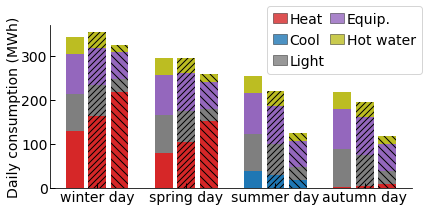

In [29]:
fs = 14
fig = plt.figure(figsize=(6.5,3))
ax1 = fig.add_subplot(111)
current_palette = sns.color_palette("tab10", 10)
endUseColors = [current_palette[3],current_palette[0],current_palette[7],current_palette[4],current_palette[8]]
colors = [current_palette[2],current_palette[1]]
hatchling = [None, '////', '\\\\\\']
xbar = np.arange(12)
xbar[3:]+=1
xbar[6:]+=1
xbar[9:]+=1
for j in range(12):
    rem = j%3
    for k in range(5):
        if k==0:
            ax1.bar(xbar[j], seasonEndUses[j,k]/1000, color=endUseColors[k], hatch=hatchling[rem])
        else:
            ax1.bar(xbar[j], seasonEndUses[j,k]/1000, bottom=np.sum(seasonEndUses[j,0:k])/1000, \
                    color=endUseColors[k], hatch=hatchling[rem])

ax1.tick_params(axis='x', labelsize=fs, pad=2)
ax1.tick_params(axis='y', labelsize=fs, pad=2)
ax1.set_ylabel('Daily consumption (MWh)', fontsize=fs, labelpad=0)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()  
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black') 
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params('both', length=5, width=1, which='major')
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False)
ax1.set_xticks([1,5,9,13])
ax1.set_xticklabels(['winter day','spring day','summer day','autumn day'])
# ax1.set_yticks(np.arange(0,1251,250))

r1 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[3], alpha=0.8,  edgecolor='black', linewidth=0.5)
r3 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[7], alpha=0.8,  edgecolor='black', linewidth=0.5)
r4 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[4], alpha=0.8,  edgecolor='black', linewidth=0.5)
r5 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[8], alpha=0.8, edgecolor='black', linewidth=0.5)
r2 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[0], alpha=0.8,  edgecolor='black', linewidth=0.5)
ax1.legend([r1,r2,r3,r4,r5], ['Heat', 'Cool', 'Light', 'Equip.', 'Hot water'], fontsize=fs, \
           loc=[0.6,0.7], ncol=2, columnspacing=0.4, handlelength=1, handletextpad=0.2)

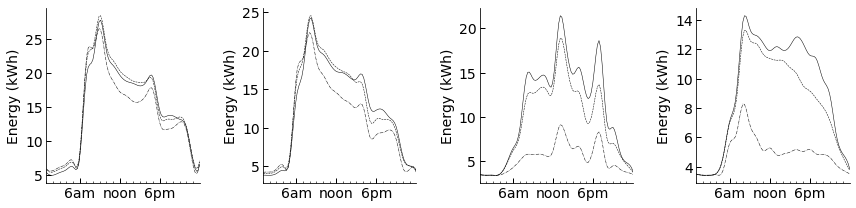

In [30]:
# make a figure break energy use broken down by load type for each season day in each scenario
SLabels = ['DOE reference', 'Low impact', 'High impact']
fig = plt.figure(figsize=(12,3))
fs = 14
LS = ['-','--','-.']

axs = []
for j in range(4):
    ax1 = fig.add_subplot(1,4,j+1)
    axs.append(ax1)

counter = 0
for scenarioIndex in range(3):
    
    for counter,season in enumerate(['winter', 'spring', 'summer', 'autumn']):
        
        if season == 'winter':
            start = 0
            end = 24
        elif season == 'spring':
            start = 24
            end = 48
        elif season == 'summer':
            start = 48
            end = 72
        elif season == 'autumn':
            start = 72
            end = 96 

        allUses = np.zeros((5,24))
        allUses[0,:] = np.sum(heatUse[scenarioIndex][:,start:end], axis=0)/1000
        allUses[1,:] = np.sum(coolUse[scenarioIndex][:,start:end], axis=0)/1000
        allUses[2,:] = np.sum(LGTUse[scenarioIndex][:,start:end], axis=0)/1000
        allUses[3,:] = np.sum(PLGUse[scenarioIndex][:,start:end], axis=0)/1000
        allUses[4,:] = np.sum(DHWUse[scenarioIndex][:,start:end], axis=0)/1000

        cumSumUses = []
        for j, a in enumerate(allUses):
            cumSumUses.append(np.sum(allUses[0:j+1,:], axis=0))   

        interpUses = np.zeros((len(cumSumUses),100))
        for j,y in enumerate(cumSumUses):
            xnew = np.linspace(1, 24, num=100, endpoint=True)
            f = interp1d(hours, y, kind='cubic')
            interpUses[j] = f(xnew)
        axs[counter].plot(xnew, interpUses[j], color='k', linestyle=LS[scenarioIndex], linewidth=0.5)
            
for j in range(4):
    axs[j].set_xticks(np.arange(6,24,6))
    axs[j].set_xticks(np.arange(1,24,1), minor=True)
#     axs[j].set_yticks(np.arange(0,106,5), minor=True)
    axs[j].set_xticklabels(['6am', 'noon', '6pm'])
    axs[j].set_xlim([1,24])
#     axs[j].set_ylim([0,109])
    axs[j].tick_params('both', length=5, width=1, which='major', labelsize=fs)
    axs[j].spines["top"].set_visible(False)  
    axs[j].spines["right"].set_visible(False)
    axs[j].set_ylabel('Energy (kWh)', fontsize=fs)

fig.tight_layout()

get the energy use results for the energy efficiency scenarios

In [31]:
fileList_control_ins, fileList_s1_ins, fileList_s2_ins = [], [], []
for sID in SDLIDs:
    for entry in glob.glob('../EPS_Results/Ins_upgrade/*control_ins.csv'):
        if sID in entry:
            fileList_control_ins.append( entry )
    for entry in glob.glob('../EPS_Results/Ins_upgrade/*experiment1_ins.csv'):
        if sID in entry:
            fileList_s1_ins.append( entry )
    for entry in glob.glob('../EPS_Results/Ins_upgrade/*experiment2_ins.csv'):
        if sID in entry:
            fileList_s2_ins.append( entry )

fileList_control_eqp, fileList_s1_eqp, fileList_s2_eqp = [], [], []
for sID in SDLIDs:
    for entry in glob.glob('../EPS_Results/Eqp_upgrade/*control_eqp.csv'):
        if sID in entry:
            fileList_control_eqp.append( entry )
    for entry in glob.glob('../EPS_Results/Eqp_upgrade/*experiment1_eqp.csv'):
        if sID in entry:
            fileList_s1_eqp.append( entry )
    for entry in glob.glob('../EPS_Results/Eqp_upgrade/*experiment2_eqp.csv'):
        if sID in entry:
            fileList_s2_eqp.append( entry )

In [32]:
def get_E_use_results(f):
    heatUse, coolUse = np.zeros((96)), np.zeros((96))
    DHWUse = np.zeros((96))
    PLGUse, LGTUse = np.zeros((96)), np.zeros((96))
    with open(f, 'rb') as csvfile:
        fileReader = csv.reader(csvfile, delimiter=',')
        headings = []
        for k, row in enumerate(fileReader):
            if k < 1:
                for entry in row:
                    headings.append( entry )                    
            else:
                for l, entry in enumerate(row):
                    #print l, headings[l]
                    if 'Zone Lights Electric' in headings[l]:
                        LGTUse[k-1]=LGTUse[k-1]+float(entry)/kWh
                    if 'Zone Electric Equipment' in headings[l]:
                        PLGUse[k-1]=PLGUse[k-1]+float(entry)/kWh
                    if 'Zone Ideal Loads Supply Air Total Heating Energy' in headings[l]:
                        heatUse[k-1]=heatUse[k-1]+float(entry)/kWh
                    if 'Zone Ideal Loads Supply Air Total Cooling Energy' in headings[l]:
                        coolUse[k-1]=coolUse[k-1]+float(entry)/kWh
                    if ':Water Use Equipment Heating Energy' in headings[l]:
                        DHWUse[k-1]=DHWUse[k-1]+float(entry)/kWh
    return PLGUse, LGTUse, DHWUse, heatUse, coolUse

In [33]:
runs=['reference','scenario1','scenario2']

In [34]:
lists_of_files = [fileList_control_ins, fileList_s1_ins, fileList_s2_ins]
entry1 = 'ins_upgrade'
# want to look at Lighting, Plugloads, DHW, Heat, Cool
for j in range(3):
    for f in lists_of_files[j]:
        idx = f.split('upgrade/')[1].split('_')[0]
        try:
            results[idx][entry1]
        except:
            results[idx][entry1] = {}
        results[idx][entry1][runs[j]] = {}
        results[idx][entry1][runs[j]]['plg'], results[idx][entry1][runs[j]]['lgt'], \
        results[idx][entry1][runs[j]]['dhw'], results[idx][entry1][runs[j]]['het'], \
        results[idx][entry1][runs[j]]['col'] = \
        get_E_use_results(f)

In [35]:
# change the heatUse and coolUse in s2
for f in lists_of_files[2]:
    idx = f.split('upgrade/')[1].split('_')[0]
    mobOcc = SDLBuildings[idx]['total_occupancy24']
    maxOcc = np.max( SDLBuildings[idx]['total_occupancy24'] )

In [36]:
lists_of_files = [fileList_control_eqp, fileList_s1_eqp, fileList_s2_eqp]
entry1 = 'eqp_upgrade'
# want to look at Lighting, Plugloads, DHW, Heat, Cool
for j in range(3):
    for f in lists_of_files[j]:
        idx = f.split('upgrade/')[1].split('_')[0]
        try:
            results[idx][entry1]
        except:
            results[idx][entry1] = {}
        results[idx][entry1][runs[j]] = {}
        results[idx][entry1][runs[j]]['plg'], results[idx][entry1][runs[j]]['lgt'], \
        results[idx][entry1][runs[j]]['dhw'], results[idx][entry1][runs[j]]['het'], \
        results[idx][entry1][runs[j]]['col'] = \
        get_E_use_results(f)

In [37]:
# change the heatUse and coolUse in s2
for f in lists_of_files[2]:
    idx = f.split('upgrade/')[1].split('_')[0]
    mobOcc = SDLBuildings[idx]['total_occupancy24']
    maxOcc = np.max( SDLBuildings[idx]['total_occupancy24'] )

In [38]:
with open('../PickledData/UBEMdata/buildings.pickle', 'rb') as handle:
    oldVals = pickle.load(handle)
print 'There are now', len(oldVals), 'buildings'
# remove the oldVal buildings where we currently don't get an output

# These are saved these as a list in _5_, however create your own list if running E+ independently
with open('../Intermediate_Results/problemBuildingsList.pickle', 'rb') as handle:
    problemBees = pickle.load(handle)
    
for bID in oldVals.keys():
    if bID in problemBees:
        del oldVals[bID]
print 'There are now', len(oldVals), 'buildings'

# ensure that have results for all
for bID in oldVals.keys():
    if bID not in results.keys():
        #print bID
        del oldVals[bID]
print 'There are now', len(oldVals), 'buildings'

There are now 325 buildings
There are now 325 buildings
There are now 318 buildings


In [39]:
# upgrade equip for these uses
buildingsWithApartment = []
for j,b in enumerate(oldVals.keys()):
    usesSet = set([oldVals[b]['zones'][z]['use'] for z in oldVals[b]['zones']])
    if 'AppM' in usesSet:
        buildingsWithApartment.append(b)
        
# upgrade equip for these uses
possibles = [u'Mall', u'RetS', u'OffM', u'ReSd']
buildingsWithOffice = []
for j,b in enumerate(oldVals.keys()):
    usesSet = set([oldVals[b]['zones'][z]['use'] for z in oldVals[b]['zones']])
    #if 'OffM' in usesSet:
    if any([substring in usesSet for substring in possibles]):
        buildingsWithOffice.append(b)

In [40]:
# now get the total usages for all scenarios and the reults for each building

In [41]:
def get_avdaily_totals_gas(building, nDays):
    gas_use_control = (np.sum(building['reference']['het'])+np.sum(building['reference']['dhw']))/nDays
    try:
        gas_use_control_i = (np.sum(building['ins_upgrade']['reference']['het'])+\
                         np.sum(building['ins_upgrade']['reference']['dhw']))/nDays
    except:
        gas_use_control_i = 0+gas_use_control
    try:
        gas_use_control_e = (np.sum(building['eqp_upgrade']['reference']['het'])+\
                         np.sum(building['eqp_upgrade']['reference']['dhw']))/nDays
    except:
        gas_use_control_e = 0+gas_use_control
    ################# s1 #########################
    gas_use_s1 = (np.sum(building['scenario1']['het'])+np.sum(building['scenario1']['dhw']))/nDays
    try:
        gas_use_s1_i = (np.sum(building['ins_upgrade']['scenario1']['het'])+\
                         np.sum(building['ins_upgrade']['scenario1']['dhw']))/nDays
    except:
        gas_use_s1_i = 0+gas_use_s1
    try:
        gas_use_s1_e = (np.sum(building['eqp_upgrade']['scenario1']['het'])+\
                         np.sum(building['eqp_upgrade']['scenario1']['dhw']))/nDays
    except:
        gas_use_s1_e = 0+gas_use_s1
    ################# s2 ##########################    
    gas_use_s2 = (np.sum(building['scenario2']['het'])+np.sum(building['scenario2']['dhw']))/nDays
    try:
        gas_use_s2_i = (np.sum(building['ins_upgrade']['scenario2']['het'])+\
                         np.sum(building['ins_upgrade']['scenario2']['dhw']))/nDays
    except:
        gas_use_s2_i = 0+gas_use_s2
    try:
        gas_use_s2_e = (np.sum(building['eqp_upgrade']['scenario2']['het'])+\
                         np.sum(building['eqp_upgrade']['scenario2']['dhw']))/nDays
    except:
        gas_use_s2_e = 0+gas_use_s2
    return gas_use_control, gas_use_control_i, gas_use_control_e, \
            gas_use_s1, gas_use_s1_i, gas_use_s1_e, \
            gas_use_s2, gas_use_s2_i, gas_use_s2_e

In [42]:
def get_avdaily_totals_elec(building, nDays):
    elec_use_control = (np.sum(building['reference']['lgt'])+np.sum(building['reference']['plg'])+\
                        np.sum(building['reference']['col']))/nDays
    try:
        elec_use_control_i = (np.sum(building['ins_upgrade']['reference']['lgt'])+\
                         np.sum(building['ins_upgrade']['reference']['plg'])+\
                         np.sum(building['ins_upgrade']['reference']['col']))/nDays
    except:
        elec_use_control_i = 0+elec_use_control
    try:
        elec_use_control_e = (np.sum(building['eqp_upgrade']['reference']['lgt'])+\
                         np.sum(building['eqp_upgrade']['reference']['plg'])+\
                         np.sum(building['eqp_upgrade']['reference']['col']))/nDays
    except:
        elec_use_control_e = 0+elec_use_control
    
    elec_use_s1 = (np.sum(building['scenario1']['lgt'])+np.sum(building['scenario1']['plg'])\
                   +np.sum(building['scenario1']['col']))/nDays
    try:
        elec_use_s1_i = (np.sum(building['ins_upgrade']['scenario1']['lgt'])+\
                         np.sum(building['ins_upgrade']['scenario1']['plg'])+\
                         np.sum(building['ins_upgrade']['scenario1']['col']))/nDays
    except:
        elec_use_s1_i = 0+elec_use_s1
    try:
        elec_use_s1_e = (np.sum(building['eqp_upgrade']['scenario1']['lgt'])+\
                         np.sum(building['eqp_upgrade']['scenario1']['plg'])+\
                         np.sum(building['eqp_upgrade']['scenario1']['col']))/nDays
    except:
        elec_use_s1_e = 0+elec_use_s1
    ####################################################    
    elec_use_s2 = (np.sum(building['scenario2']['lgt'])+np.sum(building['scenario2']['plg'])\
                   +np.sum(building['scenario2']['col']))/nDays
    try:
        elec_use_s2_i = (np.sum(building['ins_upgrade']['scenario2']['lgt'])+\
                         np.sum(building['ins_upgrade']['scenario2']['plg'])+\
                         np.sum(building['ins_upgrade']['scenario2']['col']))/nDays
    except:
        elec_use_s2_i = 0+elec_use_s2
    try:
        elec_use_s2_e = (np.sum(building['eqp_upgrade']['scenario2']['lgt'])+\
                         np.sum(building['eqp_upgrade']['scenario2']['plg'])+\
                         np.sum(building['eqp_upgrade']['scenario2']['col']))/nDays
    except:
        elec_use_s2_e = 0+elec_use_s2
    return elec_use_control, elec_use_control_i, elec_use_control_e, \
            elec_use_s1, elec_use_s1_i, elec_use_s1_e, \
            elec_use_s2, elec_use_s2_i, elec_use_s2_e

In [43]:
nDays = 4.
for bID in results.keys():
    [a,b,c,d,e,f,g,h,i] = \
    get_avdaily_totals_gas(results[bID], nDays)
    results[bID]['gas_use_control'] = a
    results[bID]['gas_use_control_i'] = b
    results[bID]['gas_use_control_e'] = c
    results[bID]['gas_use_scenario1'] = d
    results[bID]['gas_use_scenario1_i'] = e
    results[bID]['gas_use_scenario1_e'] = f
    results[bID]['gas_use_scenario2'] = g
    results[bID]['gas_use_scenario2_i'] = h
    results[bID]['gas_use_scenario2_e'] = i
    [a,b,c,d,e,f,g,h,i] = get_avdaily_totals_elec(results[bID], nDays)
    results[bID]['elec_use_control'] = a
    results[bID]['elec_use_control_i'] = b
    results[bID]['elec_use_control_e'] = c
    results[bID]['elec_use_scenario1'] = d
    results[bID]['elec_use_scenario1_i'] = e
    results[bID]['elec_use_scenario1_e'] = f
    results[bID]['elec_use_scenario2'] = g
    results[bID]['elec_use_scenario2_i'] = h
    results[bID]['elec_use_scenario2_e'] = i    

In [44]:
multiUses = []
single = 0
singleUses = []
singleUseBuildings = []
multiUseBuildings = []
for j,b in enumerate(oldVals.keys()):
    usesSet = set([oldVals[b]['zones'][z]['use'] for z in oldVals[b]['zones']])
    if len(usesSet)==1:
        single+=1
        singleUses.append( oldVals[b]['zones'][z]['use'] )
        singleUseBuildings.append(b)
    else:
        multiUses.append([use for use in usesSet])
        multiUseBuildings.append(b)
            
print 'There are', single, 'single use buildings'

There are 195 single use buildings


In [45]:
# split into res,ret,off, res+ret, res+off, ret+off,other
buildingTypes = [[] for _ in xrange(7)]
for zU in set(singleUses):
    #print 'There are', len([x for x in singleUses if x==zU]), zU, 'buildings'
    L = [singleUseBuildings[jjj] for jjj,x in enumerate(singleUses) if x==zU]
    #print L
    if zU in ['AppM']:
        for entry in L:
            buildingTypes[0].append(entry)
    if zU in ['RetS', 'Mall']:
        for entry in L:
            buildingTypes[1].append(entry)
    if zU in ['OffM']:
        for entry in L:
            buildingTypes[2].append(entry)
    if zU in ['Gara', 'ReSd','HotS', 'HotL']:
        for entry in L:
            buildingTypes[6].append(entry)
    
#print multiUses
unique_data = [list(x) for x in set(tuple(x) for x in multiUses)]
#print unique_data
for u in unique_data:
    #print u
    #print len([x for x in multiUses if x==u])
    L = [multiUseBuildings[jjj] for jjj,x in enumerate(multiUses) if x==u]
    if u in [[u'RetS', u'AppM', u'OffM', u'ReSd']]:
        for entry in L:
            buildingTypes[6].append(entry)        
    if u in [[u'OffM', u'ReSd']]:
        for entry in L:
            buildingTypes[6].append(entry)
    if u in [[u'RetS', u'HotS']]:
        for entry in L:
            buildingTypes[3].append(entry)
    if u in [[u'RetS', u'ReSd']]:
        for entry in L:
            buildingTypes[6].append(entry)
    if u in [[u'AppM', u'HotL']]:
        for entry in L:
            buildingTypes[6].append(entry)
    if u in [[u'RetS', u'OffM']]:
        for entry in L:
            buildingTypes[5].append(entry)
    if u in [[u'HotS', u'ReSd']]:
        for entry in L:
            buildingTypes[6].append(entry)
    if u in [[u'RetS', u'HotL']]:
        for entry in L:
            buildingTypes[3].append(entry)
    if u in [[u'HotL', u'HotS']]:
        for entry in L:
            buildingTypes[6].append(entry)
    if u in [[u'AppM', u'OffM']]:
        for entry in L:
            buildingTypes[4].append(entry)
    if u in [[u'HotL', u'ReSd']]:
        for entry in L:
            buildingTypes[6].append(entry)
    if u in [[u'AppM', u'Mall']]:
        for entry in L:
            buildingTypes[3].append(entry)
    if u in [[u'AppM', u'ReSd']]:
        for entry in L:
            buildingTypes[6].append(entry)
    if u in [[u'RetS', u'AppM']]:
        for entry in L:
            buildingTypes[3].append(entry)

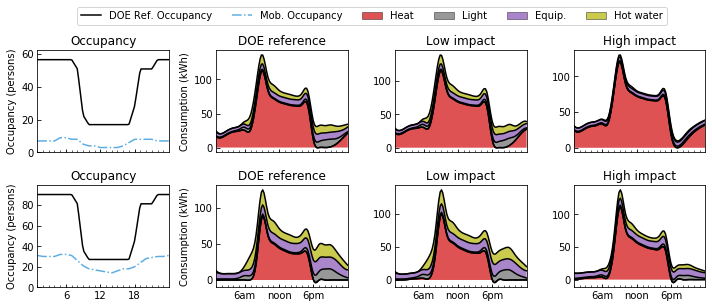

In [46]:
demoBuildings = [oldVals.keys()[0], oldVals.keys()[1]]
fig, ax = plt.subplots(2, 4, sharex='col')
fig.set_size_inches(10,4)
start, end = 0, 24
titles2 = ['Occupancy','DOE reference','Low impact','High impact']
for j in range(len(demoBuildings)):
    counter = 0
    bui = demoBuildings[j]#possDemos[j][0]
    useSDL = [u for u in SDLBuildings[bui] if 'total' not in u and 'geo' not in u][0]
    total_occ = np.zeros((24))
    for z in oldVals[bui]['zones'].values():
        total_occ += np.asarray( oldVals[bui]['occupancy'][oldVals[bui]['peopleSchedules'][z['people']]] ) \
            *z['area']*z['PCA']
            
    xnew = np.linspace(1, 24, num=100, endpoint=True)
    if j in [0,1]:
        f = interp1d(hours, SDLBuildings[bui][useSDL]['occupancy24'], kind='linear')
    else:
        f = interp1d(hours, SDLBuildings[bui][useSDL]['occupancy24'], kind='cubic')
    interpOcc = f(xnew)
    line1, = ax[j, counter].plot(xnew, interpOcc, color='#5DADE2', linestyle='-.')
    f = interp1d(hours, total_occ, kind='linear')
    interpOcc = f(xnew)
    line2, = ax[j, counter].plot(xnew, interpOcc, color='k')
    ax[j,counter].set_xlim([1,24])
    ax[j,counter].set_xticks(np.arange(6,24,6))
    ax[j,counter].set_xticks(np.arange(1,24,1), minor=True)
    ax[j,counter].set_ylim([0,max(interpOcc)*1.1])
    for sce in ['reference','scenario1','scenario2']:
        counter+=1
        allUses = np.zeros((5,24))
        allUses[0,:] = results[bui][sce]['het'][start:end]
        allUses[1,:] = results[bui][sce]['col'][start:end]
        allUses[2,:] = results[bui][sce]['lgt'][start:end]
        allUses[3,:] = results[bui][sce]['plg'][start:end]
        allUses[4,:] = results[bui][sce]['dhw'][start:end]

        cumSumUses = []
        for j2, a in enumerate(allUses):
            cumSumUses.append(np.sum(allUses[0:j2+1,:], axis=0))   

        interpUses = np.zeros((len(cumSumUses),100))
        for j2,y in enumerate(cumSumUses):
            xnew = np.linspace(1, 24, num=100, endpoint=True)
            f = interp1d(hours, y, kind='cubic')
            interpUses[j2] = f(xnew)
        for a in interpUses:
            ax[j,counter].plot(xnew, a, color='k')
        ax[j,counter].fill_between(xnew, 0, interpUses[0], facecolor=current_palette[3], alpha=0.8)
        ax[j,counter].fill_between(xnew, interpUses[0], interpUses[1], facecolor=current_palette[0], alpha=0.8)
        ax[j,counter].fill_between(xnew, interpUses[1], interpUses[2], facecolor=current_palette[7], alpha=0.8)
        ax[j,counter].fill_between(xnew, interpUses[2], interpUses[3], facecolor=current_palette[4], alpha=0.8)
        ax[j,counter].fill_between(xnew, interpUses[3], interpUses[4], facecolor=current_palette[8], alpha=0.8)
        ax[j,counter].set_xticks(np.arange(6,24,6))
        ax[j,counter].set_xticks(np.arange(1,24,1), minor=True)
        ax[j,counter].set_xticklabels(['6am', 'noon', '6pm'])
        ax[j,counter].set_xlim([1,24])
        #ax[j,counter].spines["top"].set_visible(False)  
        #ax[j,counter].spines["right"].set_visible(False)
    ax[j,1].set_ylabel('Consumption (kWh)')
    ax[j,0].set_ylabel('Occupancy (persons)')
    for counter in range(4):
        titleString = titles2[counter]
        ax[j,counter].set_title(titleString)
occMajorSteps = [25,500,50,200,10]
occMinorSteps = [5,50,5,20,1]
fig.tight_layout()
r1 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[3], alpha=0.8,  edgecolor='black', linewidth=0.5)
r3 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[7], alpha=0.8,  edgecolor='black', linewidth=0.5)
r4 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[4], alpha=0.8,  edgecolor='black', linewidth=0.5)
r5 = plt.Rectangle((0, 0), 1, 1, fc=current_palette[8], alpha=0.8, edgecolor='black', linewidth=0.5)

ax[0,0].legend([line2,line1,r1,r3,r4,r5], ['DOE Ref. Occupancy','Mob. Occupancy','Heat', 'Light', 'Equip.', 'Hot water']\
               , fontsize=10, loc=[0.3,1.25], frameon=True, ncol=6)

In [47]:
noBees = np.zeros((len(buildingTypes)))
for j,t in enumerate(buildingTypes):
    noBees[j] = len(t)    

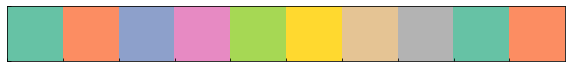

In [48]:
current_palette = sns.color_palette("Set2",10)
sns.palplot(current_palette)

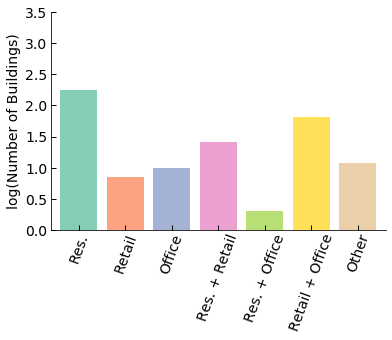

In [49]:
# histogram of Building Type
fig = plt.figure()
ax1 = fig.add_subplot(111)
for j in range(len(buildingTypes)):
    b = ax1.bar(j+1, np.log10(noBees[j]), color=current_palette[j], alpha=0.8)
ax1.set_ylim([0,3.5])

typeLabz = ['Res.', 'Retail', 'Office', 'Res. + Retail', 'Res. + Office', 'Retail + Office', 'Other']

ax1.set_xticks(np.arange(1,8,1))
ax1.set_xticklabels(typeLabz, rotation=70)
ax1.tick_params(axis='x', labelsize=fs, pad=2)
ax1.tick_params(axis='y', labelsize=fs)
ax1.set_ylabel('log(Number of Buildings)', fontsize=fs)
ax1.set_xlim([0.4,7.6])
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()  
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black') 
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params('both', length=5, width=1, which='major')
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False)
#fig.savefig('../Useful_Results/buildingTypes.png', dpi=300, format='png',  bbox_inches='tight')

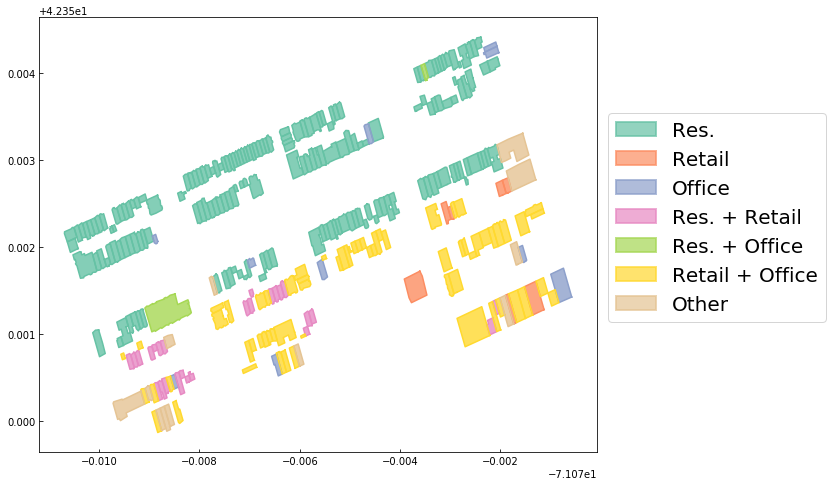

In [52]:
fig = plt.figure()
fig.set_size_inches(10,8)
ax1 = fig.add_subplot(111)
for eNo, entry in enumerate(buildingTypes):
    ptchs = []
    for bID in entry:
        longitudes = [x[0] for x in SDLBuildings[bID]['geometry']]
        latitudes = [x[1] for x in SDLBuildings[bID]['geometry']]
        geom = np.array( zip(longitudes,latitudes) )
        ax1.plot(geom[:,0], geom[:,1], color=current_palette[eNo])
        poly = Polygon(geom)
        ptchs.append(poly)
    ax1.add_collection(PatchCollection(ptchs,facecolor=current_palette[eNo], alpha=0.8, edgecolor='none'))


rects = []
for j in range(7):
    rects.append( plt.Rectangle((0, 0), 1, 1, ec=current_palette[j], fc=current_palette[j], lw=2, alpha=0.7) )
ax1.legend(rects, typeLabz, loc=[1.02,0.3], frameon=True, fontsize=20)


# # Google Map
# outputHtml = header
# # draw box illustrating the energy study buildings area
# outputHtml += add_box(-71.09, 42.343, -71.07, 42.3576)
# # get building color and coordinate
# for eNo, entry in enumerate(buildingTypes):
#     ptchs = []
#     for bID in entry:
#         longitudes = [x[0] for x in SDLBuildings[bID]['geometry']]
#         latitudes = [x[1] for x in SDLBuildings[bID]['geometry']]
#         outputHtml += polygon_header
#         for pointIndex in range(len(latitudes)):
#             outputHtml += get_polygon_line(latitudes[pointIndex], \
#                                            longitudes[pointIndex])
#         outputHtml = outputHtml[:-2]
#         outputHtml += polygon_footer.replace("#FF0000",colors2.rgb2hex(current_palette[eNo]))

# outputHtml += footer
# with open('../Useful_Results/E_model_buildings.html', 'w') as f:
#     f.write(outputHtml)

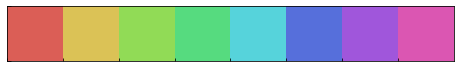

In [53]:
CPP = sns.color_palette("hls", 8)
sns.palplot(CPP)
colorLoads = [(0,0,0),CPP[5],CPP[0]]

In [54]:
# print 'there are', len(buildingTypes[0]), 'res. buildings'
# print 'there are', sum([len(x) for x in buildingTypes[1:]]), 'non-res-only buildings'

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


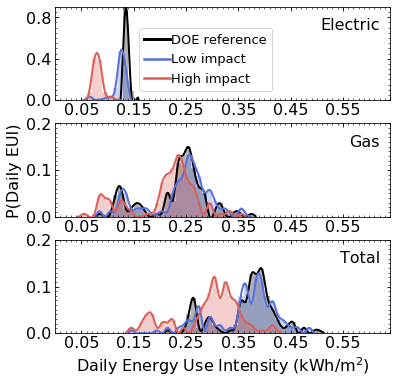

In [55]:
nDays = 4.

fs = 16
# plot histograms for each use type
elec_runs = ['elec_use_control', 'elec_use_scenario1', 'elec_use_scenario2']
gas_runs = ['gas_use_control', 'gas_use_scenario1', 'gas_use_scenario2']
sceneColors = ['b', 'g', 'r']
titles = ['Plug loads', 'Hot water loads', 'Lighting loads', 'Heating loads']

# nDays is the number of days

fig = plt.figure()
fig.set_size_inches(6,6)
axs = []
axs.append(fig.add_subplot(311))
axs.append(fig.add_subplot(312))
axs.append(fig.add_subplot(313))
for jay in range(3):
    Totals = np.zeros((len(buildingTypes[0])))
    #for l in range(3):
    Elec_use, Gas_use = np.zeros((len(buildingTypes[0]))), np.zeros((len(buildingTypes[0])))
    areasBui = np.zeros((len(buildingTypes[0])))
    for kay,bID in enumerate(buildingTypes[0]):
        ar = sum(oldVals[bID]['zones'][z]['area'] for z in oldVals[bID]['zones'])
        Elec_use[kay] = results[bID][elec_runs[jay]]/ar
        Gas_use[kay] = results[bID][gas_runs[jay]]/ar
        Totals[kay] = Elec_use[kay] + Gas_use[kay]
        areasBui[kay] = ar

    eBins = np.arange(0,0.65,0.01)
    for l in range(3):
        if l==0:
            E_use = np.copy(Elec_use)
        if l==1:
            E_use = np.copy(Gas_use)
        if l==2:
            E_use = np.copy(Totals)
        eHist, eEdges = np.histogram(E_use, eBins, density=False)
        xnew = np.linspace(eBins[0],eBins[-1],300)
        power_smooth = spline(eBins-0.005,np.append(0,eHist/float(sum(eHist))),xnew)
        for PS in range(len(power_smooth)):
            if xnew[PS]<min(E_use)-0.01:
                power_smooth[PS] = -0.1
        for PS in range(len(power_smooth)):
            if xnew[PS]>max(E_use)+0.01:
                power_smooth[PS] = -0.1        
        barList = axs[l].bar(eBins[:-1]+(eEdges[1]-eEdges[0])/2, eHist/float(sum(eHist)), \
                               width=(eEdges[1]-eEdges[0]), alpha=0.3, color=colorLoads[jay], edgecolor='black', linewidth=0)
        axs[l].plot(xnew,power_smooth,linewidth=2,color=colorLoads[jay])

for l in range(3):    
    axs[l].tick_params(axis='both', which='major', labelsize=fs)
    axs[l].yaxis.set_ticks_position('both')
    axs[l].xaxis.set_ticks_position('both')
    if l==1:
        axs[l].set_ylabel('P(Daily EUI)', fontsize=fs)
    if l==2:
        axs[l].set_xlabel('Daily Energy Use Intensity (kWh/m$^2$)', fontsize=fs)
fig.subplots_adjust(hspace=0.25)

kL = mlines.Line2D([], [], color='k', linewidth=3, label='DOE reference')
bL = mlines.Line2D([], [], color=CPP[5], linewidth=2.5, label='Low impact')
rL = mlines.Line2D([], [], color=CPP[0], linewidth=2.5, label='High impact')
axs[0].legend(handles=[kL, bL, rL], fontsize=fs-3, handletextpad=0.1, loc=[0.25,0.1])

# getting right axis limits
for l in [0,1,2]:
    axs[l].set_xticks(np.arange(0.05,0.65,0.1))
    axs[l].set_xticks(np.arange(0,0.65,0.01), minor=True)
    axs[l].set_xlim([0,0.64])
for l in [0]:
    axs[l].set_yticks(np.arange(0,0.9,0.4))
    axs[l].set_yticks(np.arange(0,9,0.05),minor=True)
    axs[l].set_ylim([0,0.9])
for l in [1,2]:
    axs[l].set_yticks(np.arange(0,0.21,0.1))
    axs[l].set_yticks(np.arange(0,0.2,0.01),minor=True)
    axs[l].set_ylim([0,0.2])
strings = ['Electric','Gas','Total']
for l in range(3):
    axs[l].text(0.97, 0.8, strings[l], ha='right', va='center', transform=axs[l].transAxes, fontsize=fs)
    axs[l].tick_params(axis='x', which='major', pad=3)

In [56]:
newBL = []
for i in range (1,7):
    for e in buildingTypes[i]:
        newBL.append( e )

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


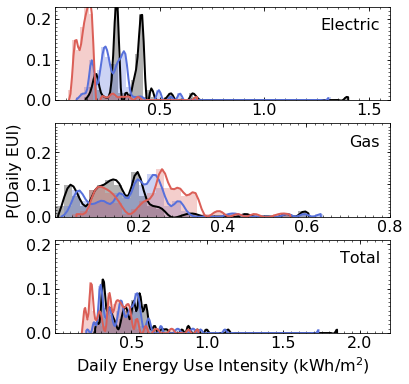

In [57]:
fig = plt.figure()
fig.set_size_inches(6,6)
axs = []
axs.append(fig.add_subplot(311))
axs.append(fig.add_subplot(312))
axs.append(fig.add_subplot(313))
for jay in range(3):
    Totals = np.zeros((len(newBL)))
    Elec_use, Gas_use = np.zeros((len(newBL))), np.zeros((len(newBL)))
    for kay,bID in enumerate(newBL):
        ar = sum(oldVals[bID]['zones'][z]['area'] for z in oldVals[bID]['zones'])
        Elec_use[kay] = results[bID][elec_runs[jay]]/ar
        Gas_use[kay] = results[bID][gas_runs[jay]]/ar
        Totals[kay] = Elec_use[kay] + Gas_use[kay]
        areasBui[kay] = ar
    
    #print 'max electric:', np.max(Elec_use), ' min electric:', np.min(Elec_use)
    #print 'max heat:', np.max(Gas_use), ' min heat:', np.min(Gas_use)
    #print 'max use:', np.max(Totals), ' min use:', np.min(Totals) 

    eBins = np.arange(0,2.2,0.02)
    for l in range(3):
        if l==0:
            E_use = np.copy(Elec_use)
        if l==1:
            E_use = np.copy(Gas_use)
        if l==2:
            E_use = np.copy(Totals)
        eHist, eEdges = np.histogram(E_use, eBins, density=False)
        xnew = np.linspace(eBins[0],eBins[-1],300)
        power_smooth = spline(eBins-0.005,np.append(0,eHist/float(sum(eHist))),xnew)
        for PS in range(len(power_smooth)):
            if xnew[PS]<min(E_use)-0.01:
                power_smooth[PS] = -0.1
        for PS in range(len(power_smooth)):
            if xnew[PS]>max(E_use)+0.01:
                power_smooth[PS] = -0.1        
        barList = axs[l].bar(eBins[:-1]+(eEdges[1]-eEdges[0])/2, eHist/float(sum(eHist)), \
                               width=(eEdges[1]-eEdges[0]), alpha=0.3, color=colorLoads[jay], edgecolor='black', linewidth=0)
        axs[l].plot(xnew,power_smooth,linewidth=2,color=colorLoads[jay])

for l in range(3):    
    axs[l].tick_params(axis='both', which='major', labelsize=fs)
    axs[l].yaxis.set_ticks_position('both')
    axs[l].xaxis.set_ticks_position('both')
    if l==1:
        axs[l].set_ylabel('P(Daily EUI)', fontsize=fs)
    if l==2:
        axs[l].set_xlabel('Daily Energy Use Intensity (kWh/m$^2$)', fontsize=fs)
fig.subplots_adjust(hspace=0.25)

kL = mlines.Line2D([], [], color='k', linewidth=3, label='DOE reference')
bL = mlines.Line2D([], [], color=CPP[5], linewidth=2.5, label='Low impact')
rL = mlines.Line2D([], [], color=CPP[0], linewidth=2.5, label='High impact')
#axs[0].legend(handles=[kL, bL, rL], fontsize=fs-3, handletextpad=0.1, loc=[0.3,0.2])

# getting right axis limits
axs[0].set_yticks(np.arange(0,0.21,0.1))
axs[0].set_yticks(np.arange(0,0.25,0.01),minor=True)
axs[0].set_ylim([0,0.23])
axs[0].set_xticks(np.arange(0.5,1.6,0.5))
axs[0].set_xticks(np.arange(0,1.6,0.05), minor=True)
axs[0].set_xlim([0,1.6])

axs[1].set_yticks(np.arange(0,0.21,0.1))
axs[1].set_yticks(np.arange(0,0.29,0.01),minor=True)
axs[1].set_ylim([0,0.29])
axs[1].set_xticks(np.arange(0.2,0.8,0.2))
axs[1].set_xticks(np.arange(0,1.6,0.02), minor=True)
axs[1].set_xlim([0,0.8])

axs[2].set_yticks(np.arange(0,0.21,0.1))
axs[2].set_yticks(np.arange(0,0.21,0.01),minor=True)
axs[2].set_ylim([0,0.21])
axs[2].set_xticks(np.arange(0.5,2.2,0.5))
axs[2].set_xticks(np.arange(0,2.2,0.05), minor=True)
axs[2].set_xlim([0,2.2])

strings = ['Electric','Gas','Total']
for l in range(3):
    axs[l].text(0.97, 0.8, strings[l], ha='right', va='center', transform=axs[l].transAxes, fontsize=fs)
    axs[l].tick_params(axis='x', which='major', pad=3)

In [58]:
newBL2 = []
for i in range (0,7):
    for e in buildingTypes[i]:
        newBL2.append( e )

In [59]:
runs = ['reference','scenario1','scenario2']
Totals, Totals_per_area = [], []
for bID in newBL2:
    # get building usage
    Total = 0
    for load in results[bID][runs[jay]].keys():
        Total += (1/nDays)*np.sum(results[bID][runs[jay]][load])
    ar = sum(oldVals[bID]['zones'][z]['area'] for z in oldVals[bID]['zones'])
    Totals.append(Total)
    Totals_per_area.append(Total/ar)
print 'Max/min total usage', max(Totals_per_area), min(Totals_per_area)

Max/min total usage 0.9362333509621014 0.14450912556306997


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


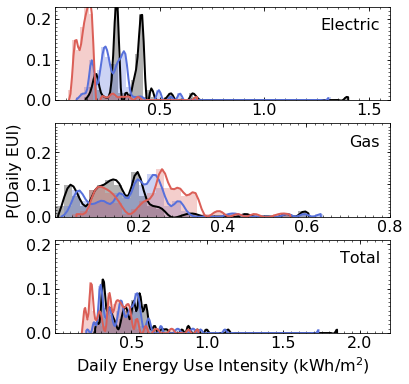

In [60]:
fig = plt.figure()
fig.set_size_inches(6,6)
axs = []
axs.append(fig.add_subplot(311))
axs.append(fig.add_subplot(312))
axs.append(fig.add_subplot(313))
for jay in range(3):
    Totals = np.zeros((len(newBL)))
    Elec_use, Gas_use = np.zeros((len(newBL))), np.zeros((len(newBL)))
    for kay,bID in enumerate(newBL):
        ar = sum(oldVals[bID]['zones'][z]['area'] for z in oldVals[bID]['zones'])
        Elec_use[kay] = results[bID][elec_runs[jay]]/ar
        Gas_use[kay] = results[bID][gas_runs[jay]]/ar
        Totals[kay] = Elec_use[kay] + Gas_use[kay]
        areasBui[kay] = ar
    
    #print 'max electric:', np.max(Elec_use), ' min electric:', np.min(Elec_use)
    #print 'max heat:', np.max(Gas_use), ' min heat:', np.min(Gas_use)
    #print 'max use:', np.max(Totals), ' min use:', np.min(Totals) 

    eBins = np.arange(0,2.2,0.02)
    for l in range(3):
        if l==0:
            E_use = np.copy(Elec_use)
        if l==1:
            E_use = np.copy(Gas_use)
        if l==2:
            E_use = np.copy(Totals)
        eHist, eEdges = np.histogram(E_use, eBins, density=False)
        xnew = np.linspace(eBins[0],eBins[-1],300)
        power_smooth = spline(eBins-0.005,np.append(0,eHist/float(sum(eHist))),xnew)
        for PS in range(len(power_smooth)):
            if xnew[PS]<min(E_use)-0.01:
                power_smooth[PS] = -0.1
        for PS in range(len(power_smooth)):
            if xnew[PS]>max(E_use)+0.01:
                power_smooth[PS] = -0.1        
        barList = axs[l].bar(eBins[:-1]+(eEdges[1]-eEdges[0])/2, eHist/float(sum(eHist)), \
                               width=(eEdges[1]-eEdges[0]), alpha=0.3, color=colorLoads[jay], edgecolor='black', linewidth=0)
        axs[l].plot(xnew,power_smooth,linewidth=2,color=colorLoads[jay])

for l in range(3):    
    axs[l].tick_params(axis='both', which='major', labelsize=fs)
    axs[l].yaxis.set_ticks_position('both')
    axs[l].xaxis.set_ticks_position('both')
    if l==1:
        axs[l].set_ylabel('P(Daily EUI)', fontsize=fs)
    if l==2:
        axs[l].set_xlabel('Daily Energy Use Intensity (kWh/m$^2$)', fontsize=fs)
fig.subplots_adjust(hspace=0.25)

kL = mlines.Line2D([], [], color='k', linewidth=3, label='DOE reference')
bL = mlines.Line2D([], [], color=CPP[5], linewidth=2.5, label='Low impact')
rL = mlines.Line2D([], [], color=CPP[0], linewidth=2.5, label='High impact')
#axs[0].legend(handles=[kL, bL, rL], fontsize=fs-3, handletextpad=0.1, loc=[0.3,0.2])

# getting right axis limits
axs[0].set_yticks(np.arange(0,0.21,0.1))
axs[0].set_yticks(np.arange(0,0.25,0.01),minor=True)
axs[0].set_ylim([0,0.23])
axs[0].set_xticks(np.arange(0.5,1.6,0.5))
axs[0].set_xticks(np.arange(0,1.6,0.05), minor=True)
axs[0].set_xlim([0,1.6])

axs[1].set_yticks(np.arange(0,0.21,0.1))
axs[1].set_yticks(np.arange(0,0.29,0.01),minor=True)
axs[1].set_ylim([0,0.29])
axs[1].set_xticks(np.arange(0.2,0.8,0.2))
axs[1].set_xticks(np.arange(0,1.6,0.02), minor=True)
axs[1].set_xlim([0,0.8])

axs[2].set_yticks(np.arange(0,0.21,0.1))
axs[2].set_yticks(np.arange(0,0.21,0.01),minor=True)
axs[2].set_ylim([0,0.21])
axs[2].set_xticks(np.arange(0.5,2.2,0.5))
axs[2].set_xticks(np.arange(0,2.2,0.05), minor=True)
axs[2].set_xlim([0,2.2])

strings = ['Electric','Gas','Total']
for l in range(3):
    axs[l].text(0.97, 0.8, strings[l], ha='right', va='center', transform=axs[l].transAxes, fontsize=fs)
    axs[l].tick_params(axis='x', which='major', pad=3)

In [78]:
# plot histograms for each use type
runs = ['reference', 'scenario1', 'scenario2']
sceneColors = ['b', 'g', 'r']
titles = ['Plug loads', 'Hot water loads', 'Lighting loads', 'Heating loads']
elecControl = [['elec_use_control','elec_use_control_i','elec_use_control_e'],\
               ['elec_use_scenario1','elec_use_scenario1_i','elec_use_scenario1_e'], \
               ['elec_use_scenario2','elec_use_scenario2_i','elec_use_scenario2_e']]
gasControl = [['gas_use_control','gas_use_control_i','gas_use_control_e'],\
              ['gas_use_scenario1','gas_use_scenario1_i','gas_use_scenario1_e'], \
               ['gas_use_scenario2','gas_use_scenario2_i','gas_use_scenario2_e']]

In [24]:
#create colormap which has EUI DIFFERENCES
minVal, maxVal = -0.2, 0.2
cmOcc = plt.cm.get_cmap('jet')
cNorm = colors2.Normalize(vmin=minVal, vmax=maxVal)
scalarMap3 = cmx.ScalarMappable(norm=cNorm, cmap=cmOcc)
scalarMap3._A = []

fig = plt.figure()
fig.set_size_inches(16,5)
axs = []
for jay in range(3):
    axs.append(fig.add_subplot(1,3,jay+1))

# Google Map
runs = ['reference', 'scenario1', 'scenario2']
for jay in range(3): 
       
    for bID in newBL2:
        longitudes = [x[0] for x in SDLBuildings[bID]['geometry']]
        latitudes = [x[1] for x in SDLBuildings[bID]['geometry']]
        
        # get building usage
        Total = results[bID][elecControl[jay][0]]+results[bID][gasControl[jay][0]] - \
        results[bID][elecControl[0][0]]-results[bID][gasControl[0][0]]
        if Total>0:
            Total+=0.2
        ar = sum(oldVals[bID]['zones'][z]['area'] for z in oldVals[bID]['zones'])
        # convert total to a color
        cl = scalarMap3.to_rgba(Total/ar)
        #print Total/ar
        colors2.rgb2hex(cl)
        
        geom = np.array( zip(longitudes,latitudes) )
        axs[jay].plot(geom[:,0], geom[:,1], color=colors2.rgb2hex(cl))
        poly = Polygon(geom)
        ptchs = []
        ptchs.append(poly)
        axs[jay].add_collection(PatchCollection(ptchs,facecolor=colors2.rgb2hex(cl), alpha=0.8, edgecolor='none'))
    
    axs[jay].set_xticks([])
    axs[jay].set_yticks([])
    
fig.tight_layout
cbar_ax = plt.axes([0.95, 0.2, 0.02, 0.6])
cbar = fig.colorbar(scalarMap3, cax=cbar_ax, ticks=np.linspace(minVal,maxVal,5), orientation='vertical')
cbar_ax.tick_params(axis='both', which='major', labelsize=fs-2)

In [67]:
total_saving_i = np.zeros((2,3))
total_saving_e = np.zeros((2,3))

for kay in range(3):
    for bID in results.keys():
        total_saving_i[0,kay] += (results[bID][gasControl[kay][0]]-results[bID][gasControl[kay][1]])
        total_saving_i[1,kay] += (results[bID][elecControl[kay][0]]-results[bID][elecControl[kay][1]])
        total_saving_e[0,kay] += (results[bID][gasControl[kay][0]]-results[bID][gasControl[kay][2]])
        total_saving_e[1,kay] += (results[bID][elecControl[kay][0]]-results[bID][elecControl[kay][2]])


In [68]:
# totals
total_use_control, total_use_s1, total_use_s2 = 0,0,0
for bID in buildingsWithApartment:
    total_use_control+=results[bID]['gas_use_control']+results[bID]['elec_use_control']
    total_use_s1+=results[bID]['gas_use_scenario1']+results[bID]['elec_use_scenario1']
    total_use_s2+=results[bID]['gas_use_scenario2']+results[bID]['elec_use_scenario2']
denom_i_tot = np.asarray([total_use_control, total_use_s1, total_use_s2])
# just gas
total_use_control, total_use_s1, total_use_s2 = 0,0,0
for bID in buildingsWithApartment:
    total_use_control+=results[bID]['gas_use_control']
    total_use_s1+=results[bID]['gas_use_scenario1']
    total_use_s2+=results[bID]['gas_use_scenario2']
denom_i_gas = np.asarray([total_use_control, total_use_s1, total_use_s2])
# just electric
total_use_control, total_use_s1, total_use_s2 = 0,0,0
for bID in buildingsWithApartment:
    total_use_control+=results[bID]['elec_use_control']
    total_use_s1+=results[bID]['elec_use_scenario1']
    total_use_s2+=results[bID]['elec_use_scenario2']
denom_i_elec = np.asarray([total_use_control, total_use_s1, total_use_s2])

In [69]:
total_use_control, total_use_s1, total_use_s2 = 0,0,0
for bID in buildingsWithOffice:
    total_use_control+=results[bID]['gas_use_control']+results[bID]['elec_use_control']
    total_use_s1+=results[bID]['gas_use_scenario1']+results[bID]['elec_use_scenario1']
    total_use_s2+=results[bID]['gas_use_scenario2']+results[bID]['elec_use_scenario2']
denom_e_tot = np.asarray([total_use_control, total_use_s1, total_use_s2])
total_use_control, total_use_s1, total_use_s2 = 0,0,0
for bID in buildingsWithOffice:
    total_use_control+=results[bID]['gas_use_control']
    total_use_s1+=results[bID]['gas_use_scenario1']
    total_use_s2+=results[bID]['gas_use_scenario2']
denom_e_gas = np.asarray([total_use_control, total_use_s1, total_use_s2])
total_use_control, total_use_s1, total_use_s2 = 0,0,0
for bID in buildingsWithOffice:
    total_use_control+=results[bID]['elec_use_control']
    total_use_s1+=results[bID]['elec_use_scenario1']
    total_use_s2+=results[bID]['elec_use_scenario2']
denom_e_elec = np.asarray([total_use_control, total_use_s1, total_use_s2])

In [72]:
denom_i_gas

array([ 262085.99164553,  274137.48752046,  245071.60124425])

In [ ]:
print 'gas savings', np.divide(total_saving_i[0,:],denom_i_gas)*100
print 'elec savings', np.divide(total_saving_i[1,:],denom_i_elec)*100
print 'total effect', np.divide(np.sum(total_saving_i, axis=0),denom_i_tot)*100

In [77]:
print 'gas savings', np.divide(total_saving_e[0,:],denom_e_gas)*100
print 'elec savings', np.divide(total_saving_e[1,:],denom_e_elec)*100
print 'total effect', np.divide(np.sum(total_saving_e, axis=0),denom_e_tot)*100

In [76]:
current_palette = sns.color_palette("tab10", 10)
colors = [current_palette[2],current_palette[1]]

fs = 16
for jay in range(2):
    fig = plt.figure(figsize=(4,2.4))
    ax1 = fig.add_subplot(1,1,1)
    if jay == 0:
        ax1.bar(np.arange(0,3), 100*total_saving_i[0,:]/denom_i_gas, width=0.5, ec='k', linewidth=1, color=colors[1])
        ax1.bar(np.arange(0,3), 100*total_saving_i[1,:]/denom_i_elec, width=0.5, ec='k', linewidth=1, color=colors[0])
        ax1.plot(np.arange(0,3), 100*np.sum(total_saving_i, axis=0)/denom_i_tot, 'k', marker='s', markersize=15, linewidth=0)
    if jay == 1:
        ax1.bar(np.arange(0,3), 100*total_saving_e[1,:]/denom_e_elec, width=0.5, ec='k', linewidth=1, color=colors[0])
        ax1.bar(np.arange(0,3), 100*total_saving_e[0,:]/denom_e_gas, width=0.5, ec='k', linewidth=1, color=colors[1])
        l1, = ax1.plot(np.arange(0,3), 100*np.sum(total_saving_e, axis=0)/denom_e_tot, 'k', marker='s', markersize=15, linewidth=0)
    
    ax1.hlines(0, -1, 3, linewidth=0.9)
    ax1.set_xlim([-.5,2.5])
    ax1.set_xticks(np.arange(0.,2.1,1))
    ax1.tick_params(axis='x', labelsize=fs, pad=2)
    ax1.tick_params(axis='y', labelsize=fs)
    ax1.set_ylabel(u'$\Delta$(Energy Use) (%)', fontsize=fs)
    ax1.get_xaxis().tick_bottom()
    ax1.get_yaxis().tick_left()  
    ax1.spines['bottom'].set_color('black')
    ax1.spines['top'].set_color('black') 
    ax1.spines['right'].set_color('black')
    ax1.spines['left'].set_color('black')
    ax1.tick_params('both', length=5, width=1, which='major')
    ax1.spines["top"].set_visible(False)  
    ax1.spines["right"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.set_xticklabels(['ASHRAE','Low','High'], rotation=45)
    ax1.set_xticklabels([])
    if jay == 0:
        ax1.set_yticks(np.arange(0,6.1,2))
        ax1.set_yticklabels([' 0.0', ' 2.0', ' 4.0', ' 6.0'])
    else:
        ax1.set_yticks(np.arange(-1,5,1))
        ax1.set_yticklabels(['-1.0', ' 0.0', ' 1.0', ' 2.0', '3.0', '4.0'])
        ax1.set_ylim([-1.5,5])
    
    # r1 = plt.Rectangle((0, 0), 1, 1, fc=colors[0], alpha=0.8,  edgecolor='black', linewidth=0.5)
    # r2 = plt.Rectangle((0, 0), 1, 1, fc=colors[1], alpha=0.8,  edgecolor='black', linewidth=0.5)

    # ax1.legend([r1,r2,l1], ['electric', 'gas','total EUI'], fontsize=fs, \
    #            loc=[-1,-0.6], ncol=3, columnspacing=0.4, handlelength=1, handletextpad=0.1)

    fig.tight_layout()

In [ ]:
# numbers for the paper
# average EUI reduction for all buildings
reduction1, reduction2 = np.zeros((len(results))), np.zeros((len(results)))
counter = 0
for bID,building in results.iteritems():
    controlUse = building['elec_use_control']+building['gas_use_control']
    s1Use = building['elec_use_scenario1']+building['gas_use_scenario1']
    s2Use = building['elec_use_scenario2']+building['gas_use_scenario2']
    reduction1[counter] = (controlUse-s1Use)/controlUse
    reduction2[counter] = (controlUse-s2Use)/controlUse
    counter+=1
print 'Average energy use reduction s1', np.mean(reduction1)
print 'Average energy use reduction s2', np.mean(reduction2)

reduction1, reduction2 = np.zeros((len(buildingTypes[0]))), np.zeros((len(buildingTypes[0])))
counter = 0
for bID in buildingTypes[0]:
    controlUse = results[bID]['elec_use_control']+results[bID]['gas_use_control']
    s1Use = results[bID]['elec_use_scenario1']+results[bID]['gas_use_scenario1']
    s2Use = results[bID]['elec_use_scenario2']+results[bID]['gas_use_scenario2']
    reduction1[counter] = (controlUse-s1Use)/controlUse
    reduction2[counter] = (controlUse-s2Use)/controlUse
    counter+=1
print 'Average residential energy use reduction s1', np.mean(reduction1)
print 'Average residential energy use reduction s2', np.mean(reduction2)

reduction1, reduction2 = np.zeros((len(newBL))), np.zeros((len(newBL)))
counter = 0
for bID in newBL:
    controlUse = results[bID]['elec_use_control']+results[bID]['gas_use_control']
    s1Use = results[bID]['elec_use_scenario1']+results[bID]['gas_use_scenario1']
    s2Use = results[bID]['elec_use_scenario2']+results[bID]['gas_use_scenario2']
    reduction1[counter] = (controlUse-s1Use)/controlUse
    reduction2[counter] = (controlUse-s2Use)/controlUse
    counter+=1
print 'Average commercial energy use reduction s1', np.mean(reduction1)
print 'Average commercial energy use reduction s2', np.mean(reduction2)

In [ ]:
# total gas use
totalGas = np.sum([results[bID]['gas_use_control'] for bID in results.keys()])
print 'total control gas %.2f'%(totalGas/1000)
totalGas = np.sum([results[bID]['gas_use_scenario1'] for bID in results.keys()])
print 'total s1 gas %.2f'%(totalGas/1000)
totalGas = np.sum([results[bID]['gas_use_scenario2'] for bID in results.keys()])
print 'total s2 gas %.2f'%(totalGas/1000)
# total elec use
totalElec = np.sum([results[bID]['elec_use_control'] for bID in results.keys()])
print 'total control elec %.2f'%(totalElec/1000)
totalElec = np.sum([results[bID]['elec_use_scenario1'] for bID in results.keys()])
print 'total s1 elec %.2f'%(totalElec/1000)
totalElec = np.sum([results[bID]['elec_use_scenario2'] for bID in results.keys()])
print 'total s2 elec %.2f'%(totalElec/1000)                     